<a href="https://colab.research.google.com/github/MKastek/time-series-notes/blob/main/decomposition_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_string = """
invoice issue date,cost of heating
11.2018,65
12.2018,91
1.2019,128
2.2019,123
3.2019,71
4.2019,22
5.2019,10
6.2019,5
7.2019,7
8.2019,8
9.2019,8
10.2019,24
2019-11-11,263
12.2019,385
1.2020,485
2.2020,455
3.2020,534
4.2020,328
5.2020,266
6.2020,281
7.2020,297
8.2020,307
9.2020,341
10.2020,365
11.2020,1225
12.2020,1377
1.2021,1373
2.2021,1153
2021-03-08,1209
4.2021,701
5.2021,569
6.2021,585
7.2021,625
8.2021,699
9.2021,730
10.2021,743
2021-11-09,1765
12.2021,1872
1/2022,1840
2/2022,1704
3/2022,2313
4/2022,1952
5/2022,1755
6/2022,979
7/2022,1271
8/2022,1384
9/2022,1360
10/2022,1363
11/2022,2719
12/2022,2961
"""

### Read Dataframe  
Invoise issue date is in different formats eg. `11.2018`, `2019-11-11`, `12/2022`. Time series ia a sequence of data points organized in time order. The sequence captures data at equally spaced points in time. Data collected irregularly is not considered a time series.  

Invoice issue date is changed to be regularly spaced - first day of month.

In [3]:
df = pd.read_csv(StringIO(data_string))

In [4]:
df

,invoice issue date,cost of heating
0,11.2018,65
1,12.2018,91
2,1.2019,128
3,2.2019,123
4,3.2019,71
5,4.2019,22
6,5.2019,10
7,6.2019,5
8,7.2019,7
9,8.2019,8


In [5]:
def clean_time_data(df: pd.DataFrame, time_column: str)-> pd.DataFrame:
  df[time_column] = df[time_column].apply(lambda x: x.replace('.','/'))
  df[time_column] = pd.to_datetime(df[time_column], errors='coerce');
  df[time_column] = df[time_column].dt.to_period('M').dt.to_timestamp()
  return df

In [6]:
df = clean_time_data(df, 'invoice issue date')

<ipython-input-5-a8ab27a19dee>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[time_column] = pd.to_datetime(df[time_column], errors='coerce');


### Time series - plot

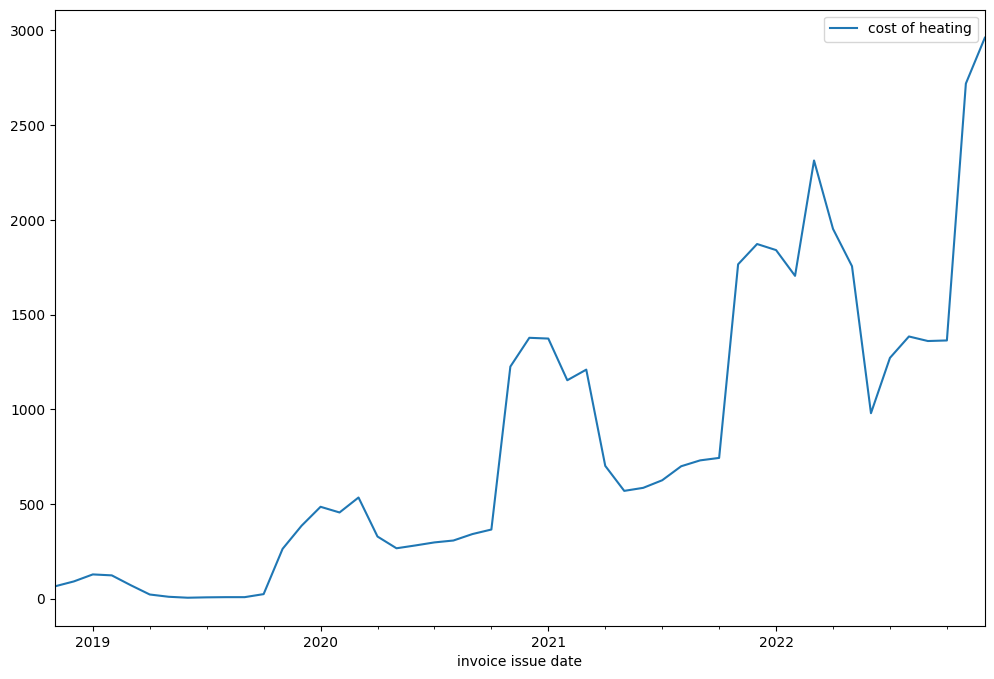

In [50]:
df.plot(x='invoice issue date', y='cost of heating',figsize=(12, 8));

### Multiplicative model  
The observed time series multiplicative models assume that the observed time series is the product of its components.  
- **Observation = Trend * Seasonality * Residual**
- It is possible to transform a multiplicative model to an additive by applying a log transformation:  
- **log(Time * Seasonality * Residual) = log(Time) + log(Seasonality) + log(Residual)**
- Multiplicative models are used when the **magnitudes of the seasonal and
residual values fluctuate with trend**  


In these example mangnitude of sesaonal value change with trend - costs are getting higher with time. Period of the series is assumed as 12 months.

In [112]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(x=df['cost of heating'], model='multiplicative', period=12)

<Figure size 1200x800 with 0 Axes>

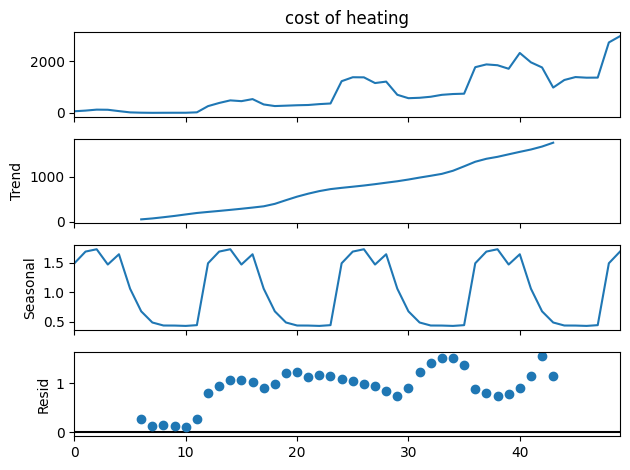

In [113]:
plt.figure(figsize=(12, 8))
result.plot()
plt.show()

### Reconstruction

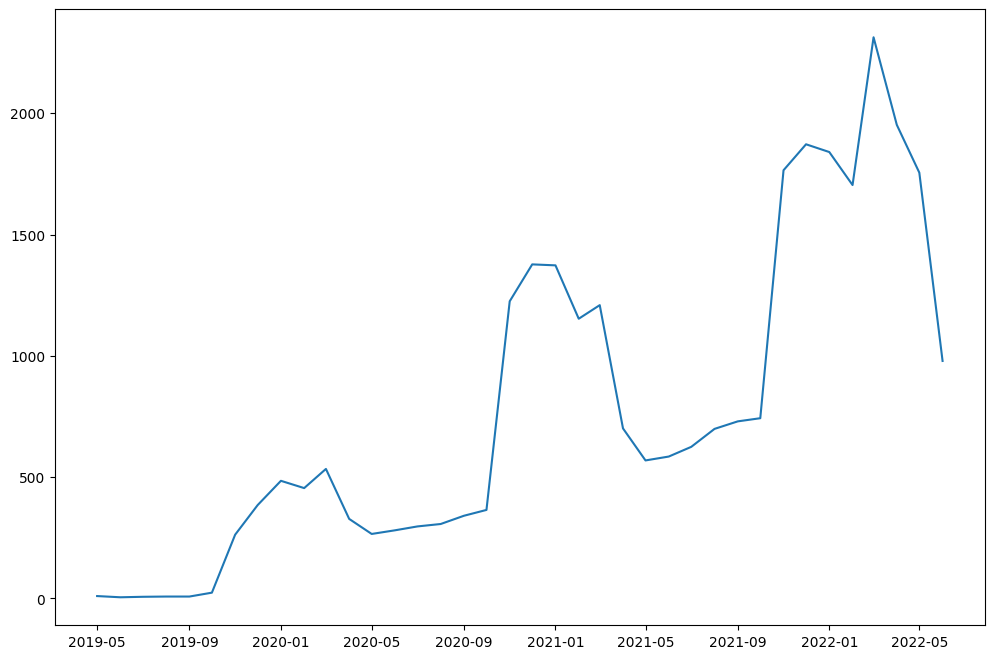

In [114]:
reconstructed = result.trend * result.seasonal * result.resid
plt.figure(figsize=(12, 8))
plt.plot(df['invoice issue date'], reconstructed);


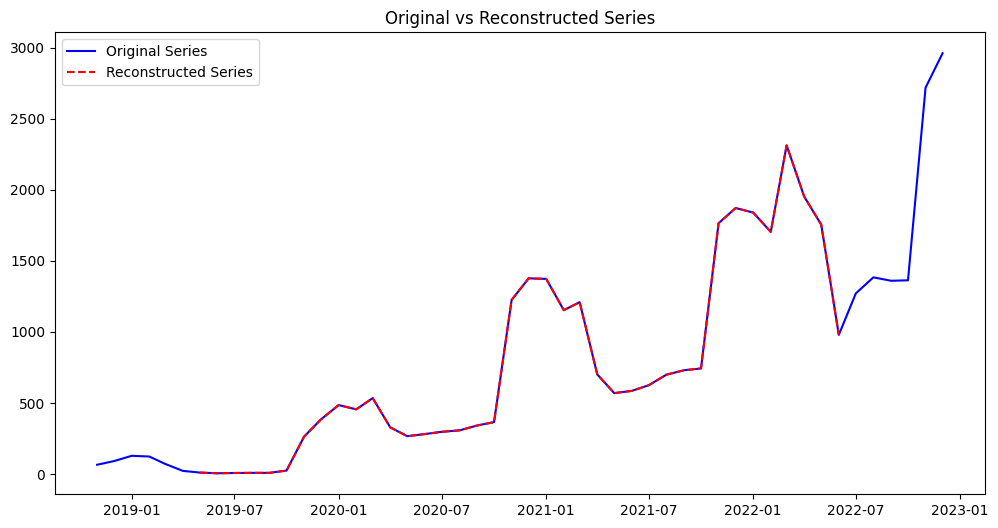

In [115]:
plt.figure(figsize=(12, 6))
plt.plot(df['invoice issue date'],df['cost of heating'], label='Original Series', color='blue')
plt.plot(df['invoice issue date'],reconstructed, label='Reconstructed Series', color='red', linestyle='--')
plt.legend()
plt.title("Original vs Reconstructed Series")
plt.show()

### Check seasonal values  
Cost of heating should lower during summer months 7,8. Reconstructed seasonal values follow the pattern.

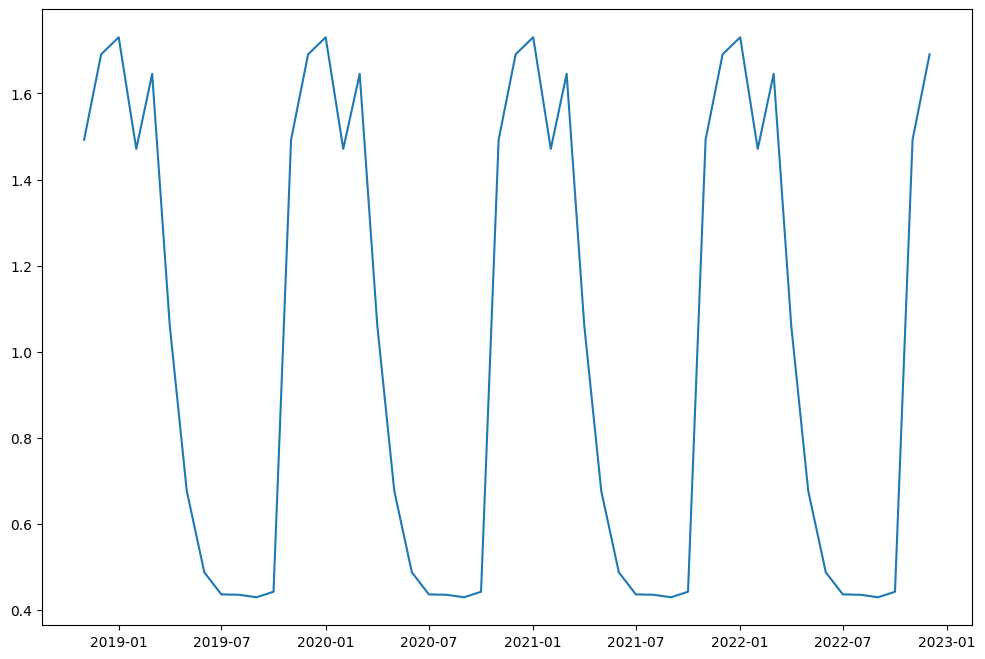

In [116]:
plt.figure(figsize=(12, 8))
plt.plot(df['invoice issue date'], result.seasonal, label='Seasonality');

### Check residual values

In [117]:
print("Residual Mean:", np.mean(result.resid))
print("Residual Variance:", np.var(result.resid))

Residual Mean: 0.9256935351159236
Residual Variance: 0.14613211260859968


In [118]:
from statsmodels.tsa.stattools import adfuller

residuals =  result.resid.dropna()
result = adfuller(residuals)
print("ADF Statistic:", result[0])
print("p-value:", result[1])
if result[1] <= 0.05:
    print("Reszty są stacjonarne")
else:
    print("Reszty NIE są stacjonarne")

ADF Statistic: -2.8219629494216205
p-value: 0.05520435651872358
Reszty NIE są stacjonarne


In [119]:
stationary_residuals = residuals.diff().dropna()